# Feature Extraction for Phoneme Recognition on TIMIT

## Goals

- Loading and testing the datasets exported by the previous notebook.
- Feature design for the LSTM-250 network.
- Feature extraction from the TIMIT dataset.
- Exporting the features as standalone dataset for training the network.
    - Feature dataset record: (phoneme, feature-sequence)

# Environment Setup

In [1]:
import torch

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading and Testing the Datasets

In [2]:
ds_path = './session/curated-dataset.pt'
ds_dict = torch.load(ds_path)
print(ds_dict.keys())
print(ds_dict['note'])

Train_ds = ds_dict['train']
Test_ds  = ds_dict['test']

print('Train_ds:', len(Train_ds))
ipd.display(Train_ds[:3])
print('Test_ds:', len(Test_ds))
ipd.display(Test_ds[:3])

dict_keys(['note', 'train', 'test'])

Notes:
- Phoneme record structure: (phoneme, path-to-audio, start-index, end-index)
- The dataset into train and test subsets.
- Some data is filtered according to a reference paper
    - SA records are removed from both datasets.
    - Only core test subset with 24 speakers are exported for testing.
    - Records missing phonetic-file (phoneme labels) are removed.
- Remapped phoneme from 61 to 39 classes.

Train_ds: 51848


[['h#', './dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV', 0, 2680],
 ['s', './dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV', 2680, 5640],
 ['aa', './dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV', 5640, 7853]]

Test_ds: 7333


[['h#', './dataset/TIMIT/data/TEST/DR4/MTLS0/SX290.WAV', 0, 2370],
 ['dh', './dataset/TIMIT/data/TEST/DR4/MTLS0/SX290.WAV', 2370, 2780],
 ['ih', './dataset/TIMIT/data/TEST/DR4/MTLS0/SX290.WAV', 2780, 3880]]

In [3]:
rec = Train_ds[1]
phone, audio_path, start, end = rec
wave, rate = librosa.load(audio_path, sr=None)
phone_wave = wave[start:end]
print(phone)
ipd.Audio(phone_wave, rate=rate)

s


## Convert to Audio dataset

Convert records from (phoneme, path-to-audio, start-index, end-index) to (phoneme, wave, rate).

In [4]:
# Given a file path, returns the audio waveform and the sampling rate.
# Mainly used for caching already loaded files.
audio_cache = {}    # Caching loaded audio files for faster processing
def getAudio(audio_path):
    if audio_path not in audio_cache:
        wave, rate = librosa.load(audio_path, sr=None)    
        audio_cache[audio_path] = (wave, rate)
    return audio_cache[audio_path]


# Given file path, start, and end indices, returns the audio slice and the sampling rate
def getAudioSlice(audio_path, start, end):
    wave, rate = getAudio(audio_path)
    return wave[start:end], rate


# Without caching: 14 seconds
# With caching: < 1sec
# Test above function
for rec in tqdm(Train_ds):    
    _, audio_path, *_ = rec
    getAudio(audio_path)

  0%|          | 0/51848 [00:00<?, ?it/s]

In [5]:
# Given a phoneme record list, returns an audio record list.
def makeAudioDS(list_phone_rec):
    audio_ds = []
    for phone_rec in list_phone_rec:
        phone, audio_path, start, end = phone_rec
        wave, rate = getAudioSlice(audio_path, start, end)
        audio_rec = [phone, wave, rate]
        audio_ds.append(audio_rec)
    return audio_ds


# Convert to audio datasets
Train_audio_ds = makeAudioDS(Train_ds)
Test_audio_ds  = makeAudioDS(Test_ds)
        
print('Train_audio_ds:', len(Train_audio_ds))
print('Test_audio_ds :', len(Test_audio_ds))

Train_audio_ds: 51848
Test_audio_ds : 7333


# Feature Design

**NOTE:**
- Feature vector is designed following [[Speech-Recog paper]](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6638947)
- Instead of mel-spectrogram coefficient, 40 MFCC coefficients are taken.
- The energy term is computed using the mfcc coefficients.
- First and second order derivatives of those terms are used.
- Total length of the feature vector: 41 x 3 = 123.

In [6]:
# Given an audio waveform, get the MFCC coefficients
# Params,
#   n_mfcc    : no. of MFCC coefficient to return
#   n_mels    : number of Mel bands to generate
#   fft_window: length of the FFT window
#   hop_len   : number of audio samples between adjacent STFT columns.
# Note: Change fft_window and hop_len to play with the sequence lengths.
def getMFCC(wave, sample_rate, n_mfcc, fft_window, hop_length, n_mels):
    mfcc = librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=n_mfcc, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
    return mfcc


# Given a sequence of mfcc coefficients, returns a sequence of corresponding energy terms
def getEnergy(mfcc_seq):
    energy_seq = np.sum(mfcc_seq**2, axis=0)
    return energy_seq


# Given a sequence, computes the derivative of order=order.
def getDelta(seq, order):
    delta = librosa.feature.delta(seq, order=order)
    return delta


# Plotting utilities ---
def plotAudio(wave, sample_rate, axis):
    duration = len(wave) / sample_rate
    time = np.linspace(0, duration, len(wave))
    axis.plot(time, wave)
    

# Use librosa.display.specshow to display 2D features
def plotSpecshow(data, fig, axis):
    img = librosa.display.specshow(data, ax=axis)
    fig.colorbar(img, ax=axis)
    return img
    

In [7]:
# Test above functions ---
# Get an audio
rec = Test_audio_ds[2]
phone, wave, rate = rec
print('phone:', phone, '  wave:', len(wave), '  rate:', rate)

mfcc = getMFCC(wave, rate, n_mfcc=40, fft_window=64, hop_length=32, n_mels=128)
print('mfcc:', mfcc.shape)

energy = getEnergy(mfcc)
print('energy:', energy.shape)

mfcc_eng = np.vstack([mfcc, energy])
print('mfcc_eng:', mfcc_eng.shape)

delta1 = getDelta(mfcc_eng, order=1)
delta2 = getDelta(mfcc_eng, order=2)
print('delta1:', delta1.shape)
print('delta2:', delta2.shape)

phone: ih   wave: 1100   rate: 16000
mfcc: (40, 35)
energy: (35,)
mfcc_eng: (41, 35)
delta1: (41, 35)
delta2: (41, 35)


/home/makabir/miniconda3/envs/pytorch/lib/python3.10/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


phoneme: ih


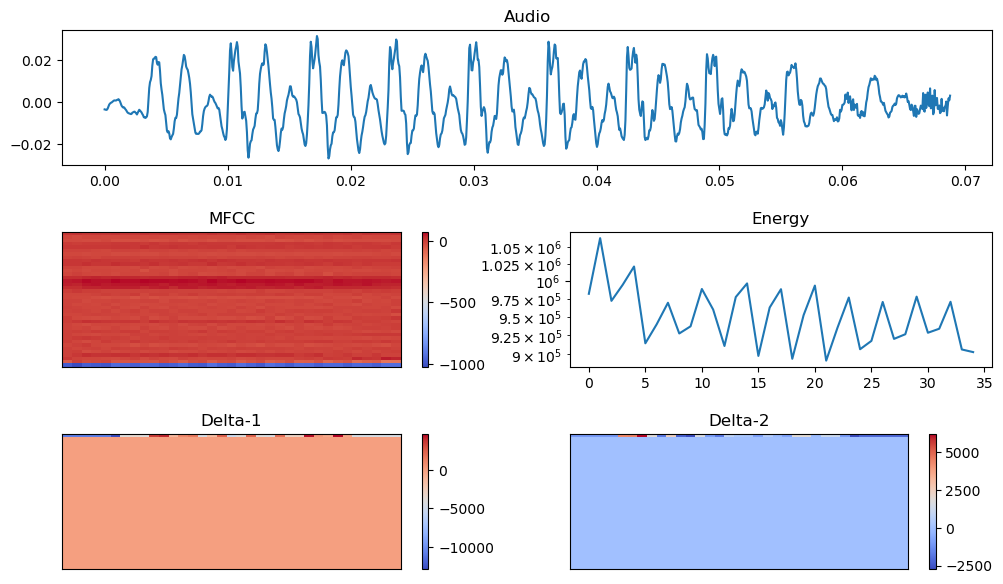

In [8]:
# Plot the features
print('phoneme:', phone)
ipd.display(ipd.Audio(wave, rate=rate))

fig = plt.figure(figsize=(3*4, 7))
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

ax_wave = fig.add_subplot(3, 1, 1)
plotAudio(wave, rate, ax_wave)
ax_wave.set_title('Audio')

ax_mfcc = fig.add_subplot(3, 2, 3)
ax_mfcc.set_title('MFCC')
plotSpecshow(mfcc, fig, ax_mfcc)

ax_energy = fig.add_subplot(3, 2, 4)
ax_energy.set_title('Energy')
ax_energy.semilogy(energy)

ax_delta1 = fig.add_subplot(3, 2, 5)
ax_delta1.set_title('Delta-1')
plotSpecshow(delta1, fig, ax_delta1)

ax_delta2 = fig.add_subplot(3, 2, 6)
ax_delta2.set_title('Delta-2')
plotSpecshow(delta2, fig, ax_delta2)

## Check Audio Dataset Distribution

Check the audio dataset to determine the parameters for the features.  

In [9]:
from math import inf as INF


# Given a audio dataset, returns the record with min and max audio lengths
def getMinMaxRec(ds_list):
    min_len = INF
    max_len = -INF
    min_rec = None
    max_rec = None
    all_len = []
    for audio_rec in ds_list:    # rec: (phoneme, wave, rate)
        phone_len = len(audio_rec[1])
        if phone_len < min_len:
            min_len = phone_len
            min_rec = audio_rec
        if phone_len > max_len:
            max_len = phone_len
            max_rec = audio_rec
        all_len.append(phone_len)
    return min_len, max_len, min_rec, max_rec, all_len

Train_ds ----
min_rec: 32 h#
max_rec: 38345 h#


Text(0.5, 1.0, 'Distribution of audio lengths')

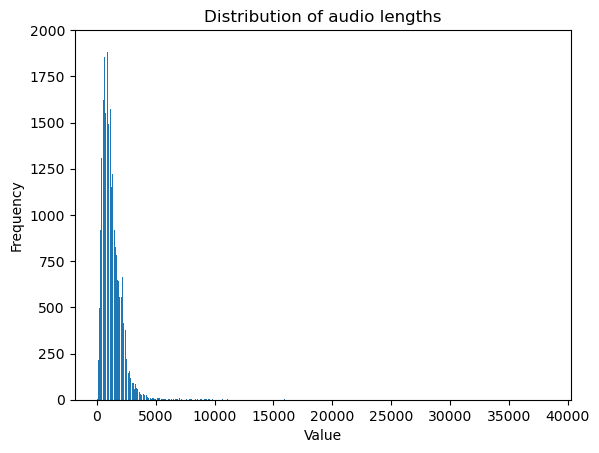

In [10]:
# Check the train dataset
min_len, max_len, min_rec, max_rec, all_len = getMinMaxRec(Train_audio_ds)
print('Train_ds ----')
print('min_rec:', min_len, min_rec[0])
print('max_rec:', max_len, max_rec[0])

wave, rate = min_rec[1:]
ipd.display(ipd.Audio(wave, rate=rate))

wave, rate = max_rec[1:]
ipd.display(ipd.Audio(wave, rate=rate))

plt.hist(all_len, bins='auto', rwidth=0.8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of audio lengths')

Test_ds ----
min_rec: 38 d
max_rec: 16810 h#


Text(0.5, 1.0, 'Distribution of audio lengths')

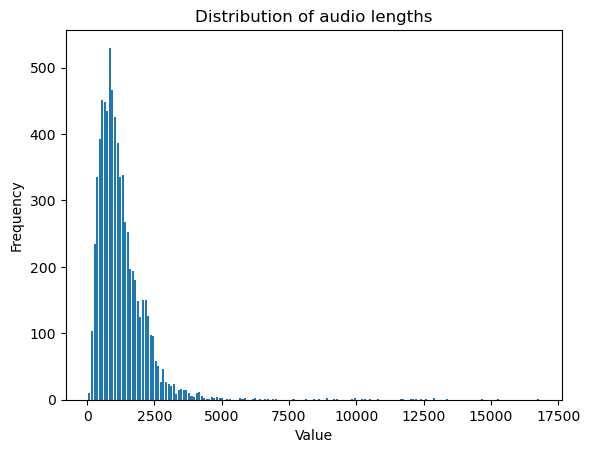

In [11]:
# Check the train dataset
min_len, max_len, min_rec, max_rec, all_len = getMinMaxRec(Test_audio_ds)
print('Test_ds ----')
print('min_rec:', min_len, min_rec[0])
print('max_rec:', max_len, max_rec[0])

wave, rate = min_rec[1:]
ipd.display(ipd.Audio(wave, rate=rate))

wave, rate = max_rec[1:]
ipd.display(ipd.Audio(wave, rate=rate))


plt.hist(all_len, bins='auto', rwidth=0.8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of audio lengths')

**NOTE:**
Based on the above observation
- n_mfcc: 40
- fft_window: 32 (<= minimum length of the audio)
- hop_length: 16 (<= fft_window/2 )
- n_mels: 128 (default value)

# Feature Extraction

In [12]:
F_n_mfcc = 40
F_fft_window = 32
F_hop_length = 16
F_n_mels = 128

F_note = f'''
F_n_mfcc    : {F_n_mfcc}
F_fft_window: {F_fft_window}
F_hop_length: {F_hop_length}
F_n_mels    : {F_n_mels}
'''

# Given an audio record, returns a feature record: (phoneme, feature-sequence)
def getFeatureRecord(audio_record):
    # Feature extraction parameters
    # Extract features from the audio-record
    phone, wave, rate = audio_record
    # compute MFCC coefficients
    mfcc = getMFCC(phone_wave, rate, n_mfcc=F_n_mfcc, fft_window=F_fft_window, hop_length=F_hop_length, n_mels=F_n_mels)
    # Compute energy from mfcc then stack on top of mfcc for deta calculation
    energy = getEnergy(mfcc)
    mfcc_eng = np.vstack([mfcc, energy])
    # compute deltas
    delta1 = getDelta(mfcc_eng, order=1)
    delta2 = getDelta(mfcc_eng, order=2)
    # stack all to make feature vector
    feat_vec = np.vstack([mfcc_eng, delta1, delta2])
    return phone, feat_vec

    
# Test above function
audio_rec = Train_audio_ds[4]
phone, feat_vec = getFeatureRecord(audio_rec)
print('phone:', phone)
print('feat_vec:', feat_vec.shape)
F_feat_len = len(feat_vec)
ipd.display(ipd.Audio(audio_rec[1], rate=audio_rec[2]))

phone: r
feat_vec: (123, 186)


In [ ]:
# Given an audio dataset, returns a list of feature dataset
# audio_ds[i]: (phone, wave, rate)
# return[i]: (phone, feature-sequence)
def makeFeatureDS(audio_ds):
    feat_ds = []
    for audio_rec in tqdm(audio_ds):
        feat_rec = getFeatureRecord(audio_rec)
        feat_ds.append(feat_rec)
    return feat_ds


# Make feature datasets
Train_feat_ds = makeFeatureDS(Train_audio_ds)
Test_feat_ds  = makeFeatureDS(Test_audio_ds)

print('Train_feat_ds:', len(Train_feat_ds))
print('Test_feat_ds :', len(Test_feat_ds))
        

  0%|          | 0/51848 [00:00<?, ?it/s]

In [ ]:
assert len(Train_feat_ds) == len(Train_ds), "Training dataset length mismatch"
assert len(Test_feat_ds) == len(Test_ds), "Test dataset length mismatch"

# Export the Feature Datasets

In [ ]:
# Export the dataset with necessary information for the next notebook
note = f'''
Notes:
- Feature record: (phone, feature_sequence)
- feature_seqence: list(feature_vector)
- len(feature_vector): {F_feat_len}

Features are extracted using following parameters''' + F_note

export_dict = {
    'note'  : note,
    'train' : Train_feat_ds,
    'test'  : Test_feat_ds,
}

print(note)

In [ ]:
# Save into an external file
save_path = './session/feature-dataset.pt'
torch.save(export_dict, save_path)
!ls -ltrh './session/'